In [1]:
import pandas as pd 
import numpy as np 
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
# import zigzag
import plotly.express as px
import plotly.graph_objects as go

# Get BTC Data 15 min

In [2]:
df = pd.read_csv("BTC_Close.csv", index_col=0)
df.index = pd.to_datetime(df.index, unit='ms')

data = df.resample('15T').last().fillna(method='ffill')

In [3]:
"""
reference:
https://github.com/jbn/ZigZag.git
"""
import numpy as np

PEAK = 1
VALLEY = -1


def identify_initial_pivot(X, up_thresh, down_thresh):
    x_0 = X[0]
    x_t = x_0

    max_x = x_0
    min_x = x_0

    max_t = 0
    min_t = 0

    up_thresh += 1
    down_thresh += 1

    for t in range(1, len(X)):
        x_t = X[t]

        if x_t / min_x >= up_thresh:
            return VALLEY if min_t == 0 else PEAK

        if x_t / max_x <= down_thresh:
            return PEAK if max_t == 0 else VALLEY

        if x_t > max_x:
            max_x = x_t
            max_t = t

        if x_t < min_x:
            min_x = x_t
            min_t = t

    t_n = len(X)-1
    return VALLEY if x_0 < X[t_n] else PEAK


def peak_valley_pivots(X, up_thresh, down_thresh):
    """
    Find the peaks and valleys of a series.

    :param X: the series to analyze
    :param up_thresh: minimum relative change necessary to define a peak
    :param down_thesh: minimum relative change necessary to define a valley
    :return: an array with 0 indicating no pivot and -1 and 1 indicating
        valley and peak


    The First and Last Elements
    ---------------------------
    The first and last elements are guaranteed to be annotated as peak or
    valley even if the segments formed do not have the necessary relative
    changes. This is a tradeoff between technical correctness and the
    propensity to make mistakes in data analysis. The possible mistake is
    ignoring data outside the fully realized segments, which may bias
    analysis.
    """
    if down_thresh > 0:
        raise ValueError('The down_thresh must be negative.')

    initial_pivot = identify_initial_pivot(X, up_thresh, down_thresh)
    t_n = len(X)
    pivots = np.zeros(t_n, dtype=np.int_)
    trend = -initial_pivot
    last_pivot_t = 0
    last_pivot_x = X[0]

    pivots[0] = initial_pivot

    # Adding one to the relative change thresholds saves operations. Instead
    # of computing relative change at each point as x_j / x_i - 1, it is
    # computed as x_j / x_1. Then, this value is compared to the threshold + 1.
    # This saves (t_n - 1) subtractions.
    up_thresh += 1
    down_thresh += 1

    for t in range(1, t_n):
        x = X[t]
        r = x / last_pivot_x

        if trend == -1:
            if r >= up_thresh:
                pivots[last_pivot_t] = trend # 上一个被标记为谷底的点
                trend = PEAK
                last_pivot_x = x
                last_pivot_t = t
            elif x < last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t
        else:
            if r <= down_thresh:
                pivots[last_pivot_t] = trend
                trend = VALLEY
                last_pivot_x = x
                last_pivot_t = t
            elif x > last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t

    if last_pivot_t == t_n-1:
        pivots[last_pivot_t] = trend # 新趋势
    elif pivots[t_n-1] == 0:
        pivots[t_n-1] = -trend # 老趋势

    return pivots


def max_drawdown(X):
    """
    Compute the maximum drawdown of some sequence.

    :return: 0 if the sequence is strictly increasing.
        otherwise the abs value of the maximum drawdown
        of sequence X
    """
    mdd = 0
    peak = X[0]

    for x in X:
        if x > peak:
            peak = x

        dd = (peak - x) / peak

        if dd > mdd:
            mdd = dd

    return mdd if mdd != 0.0 else 0.0


def pivots_to_modes(pivots):
    """
    Translate pivots into trend modes.

    :param pivots: the result of calling ``peak_valley_pivots``
    :return: numpy array of trend modes. That is, between (VALLEY, PEAK] it
    is 1 and between (PEAK, VALLEY] it is -1.
    """

    modes = np.zeros(len(pivots), dtype=np.int_)
    mode = -pivots[0]

    modes[0] = pivots[0]

    for t in range(1, len(pivots)):
        x = pivots[t]
        if x != 0:
            modes[t] = mode
            mode = -x
        else:
            modes[t] = mode

    return modes


def compute_segment_returns(X, pivots):
    """
    :return: numpy array of the pivot-to-pivot returns for each segment."""
    pivot_points = np.array(X[pivots != 0])
    return pivot_points[1:] / pivot_points[:-1] - 1.0

# 做空

In [4]:
# TODO: 加上均线
def backtest(X, rise, down, take_profit=0, output=True):
    # pivots = peak_valley_pivots(X, rise, -rise)
    allowance = 10000
    cash = 0
    shares = 0
    low = None
    high = None
    n = len(X)
    cash_array = np.zeros(n)
    shares_array = np.zeros(n)
    actions = np.zeros(n)
    up_thresh, down_thresh = rise, down
    last_buy = 1000000
    last_sell = 0
    for i in range(n):
        if i == 0:
            initial_pivot = identify_initial_pivot(X[:100], up_thresh, down_thresh) # 这个会数据泄漏
            t_n = len(X)
            pivots = np.zeros(t_n, dtype=np.int_)
            trend = -initial_pivot
            last_pivot_t = 0
            last_pivot_x = X[0]

            pivots[0] = initial_pivot
            up_thresh += 1
            down_thresh += 1
            continue
        
        t = i
        x = X[t]
        r = x / last_pivot_x

        if trend == -1:
            if r >= up_thresh: # 如果上升幅度超过阈值，则标记上个点为谷底
                pivots[last_pivot_t] = trend # 上一个被标记为谷底的点
                low = last_pivot_x
                trend = PEAK
                last_pivot_x = x
                last_pivot_t = t
            elif x < last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t
        else:
            if r <= down_thresh: # 如果下降幅度超过阈值，则标记上个点为顶点
                pivots[last_pivot_t] = trend
                high = last_pivot_x
                trend = VALLEY
                last_pivot_x = x
                last_pivot_t = t
            elif x > last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t   
                
        # if last_pivot_t == t_n-1:
        #     pivots[last_pivot_t] = trend # 新趋势
        # elif pivots[t_n-1] == 0:
        #     pivots[t_n-1] = -trend # 老趋势
            
        p = X[i] # 当前价格
        
        # if pivots[i] == -1:
        #     low = p
            
        # if pivots[i] == 1:
        #     high = p
            
        if low is None or high is None: # 确保已经有了low high
            continue

        if p < low and shares >= 0: # and p < high * (1-rise) # TODO: 增加频率，避免一下子跌太多，错过做空时机
            # 做空
            shares = -allowance / p
            cash += allowance
            if output: print("做空", p, X.index[i])
            actions[i] = -1
            last_sell = p
            
        if (p > high) and shares < 0: # and p > low * (1 + rise)
        # if (p > (0.5 * low + 0.5 * high)) and shares < 0: # 特殊止损条件
            # 平仓止损
            cash += shares * p
            if output: print("止损", p, X.index[i], "盈亏", allowance + shares * p)
            shares = 0
            actions[i] = -2
            last_buy = p
        
        if (p < take_profit * last_sell) and shares < 0:
            # 止盈
            cash += shares * p
            if output: print("止盈", p, X.index[i], "盈亏", allowance + shares * p)
            shares = 0
            actions[i] = -3
            last_buy = p
            
        if i == len(pivots) - 1: # 最后时刻清仓
            cash += shares * p
            shares = 0
        
        cash_array[i] = cash
        shares_array[i] = shares
    
    ## 计算收益
    df_pnl = pd.DataFrame({"cash": cash_array, "shares": shares_array, "price": X, "pivots": pivots, "actions": actions})
    df_pnl.index = X.index
    df_pnl["pnl"] = df_pnl["cash"] + df_pnl["shares"] * df_pnl["price"]
    
    # 计算收益率等参数
    df_pnl["ret"] = df_pnl["pnl"].diff().fillna(0) / allowance
    freq = (df_pnl.index[1] - df_pnl.index[0]).total_seconds() // 60
    rets = df_pnl.loc[df_pnl["ret"] != 0, "ret"]
    if len(rets) == 0:
        stats = {}
    else:
        time_length = rets.shape[0] * ((df_pnl.index[1] - df_pnl.index[0]).total_seconds() / 3600 / 24 / 365)
        total_return = df_pnl["pnl"][-1] / allowance
        yearly_return = total_return / time_length
        yearly_vol = df_pnl["ret"].std() * np.sqrt(60 / freq * 24 * 365)
        maxdrawdown = max(rets.cumsum().cummax() - rets.cumsum())
        sharpe = yearly_return / yearly_vol
        stats = dict(rise=rise, down=down, freq=freq, take_profit=take_profit, total_return=total_return, yearly_vol=yearly_vol, maxdrawdown=maxdrawdown, sharpe=sharpe, hold_time=time_length, start_date=X.index[0].date(), end_date=X.index[-1].date())
    # stats = [rise, total_return, yearly_vol, maxdrawdown]
    return df_pnl, pivots, actions, stats

## 参数1

做空 10174.18 2019-07-10 00:00:00
止盈 8177.91 2019-09-23 00:00:00 盈亏 1962.094242484407
做空 8359.94 2019-09-28 00:00:00
止盈 7156.14 2019-11-22 00:00:00 盈亏 1439.9624877690512
做空 7390.89 2019-11-27 00:00:00
止损 9513.21 2020-01-26 00:00:00 盈亏 -2871.5350925260664
做空 8523.61 2020-02-25 00:00:00
止盈 5361.3 2020-03-11 00:00:00 盈亏 3710.0594701071495
做空 55633.14 2021-04-15 00:00:00
止盈 50047.84 2021-04-20 00:00:00 盈亏 1003.951961007413
做空 49841.45 2021-05-10 00:00:00
止盈 36690.09 2021-05-15 00:00:00 盈亏 2638.6391246643107
做空 38796.29 2021-05-20 00:00:00
止盈 34605.15 2021-05-25 00:00:00 盈亏 1080.294017804279
做空 33380.81 2021-06-04 00:00:00
止损 40019.56 2021-07-24 00:00:00 盈亏 -1988.7923630373243
做空 59707.51 2021-11-16 00:00:00
止盈 49396.33 2021-12-01 00:00:00 盈亏 1726.9485865345923
做空 47140.54 2021-12-06 00:00:00
止盈 41864.62 2022-01-05 00:00:00 盈亏 1119.1895553169306
做空 43059.96 2022-01-10 00:00:00
止盈 36660.35 2022-01-20 00:00:00 盈亏 1486.208997871805
做空 38166.84 2022-01-25 00:00:00
止损 44313.16 2022-03-21 00:00:00 

,rise,down,freq,take_profit,total_return,yearly_vol,maxdrawdown,sharpe,hold_time,start_date,end_date
0,0.06,-0.01,7200.0,0.9,1.304671,0.46818,0.416998,2.164129,1.287671,2019-01-01,2022-07-29


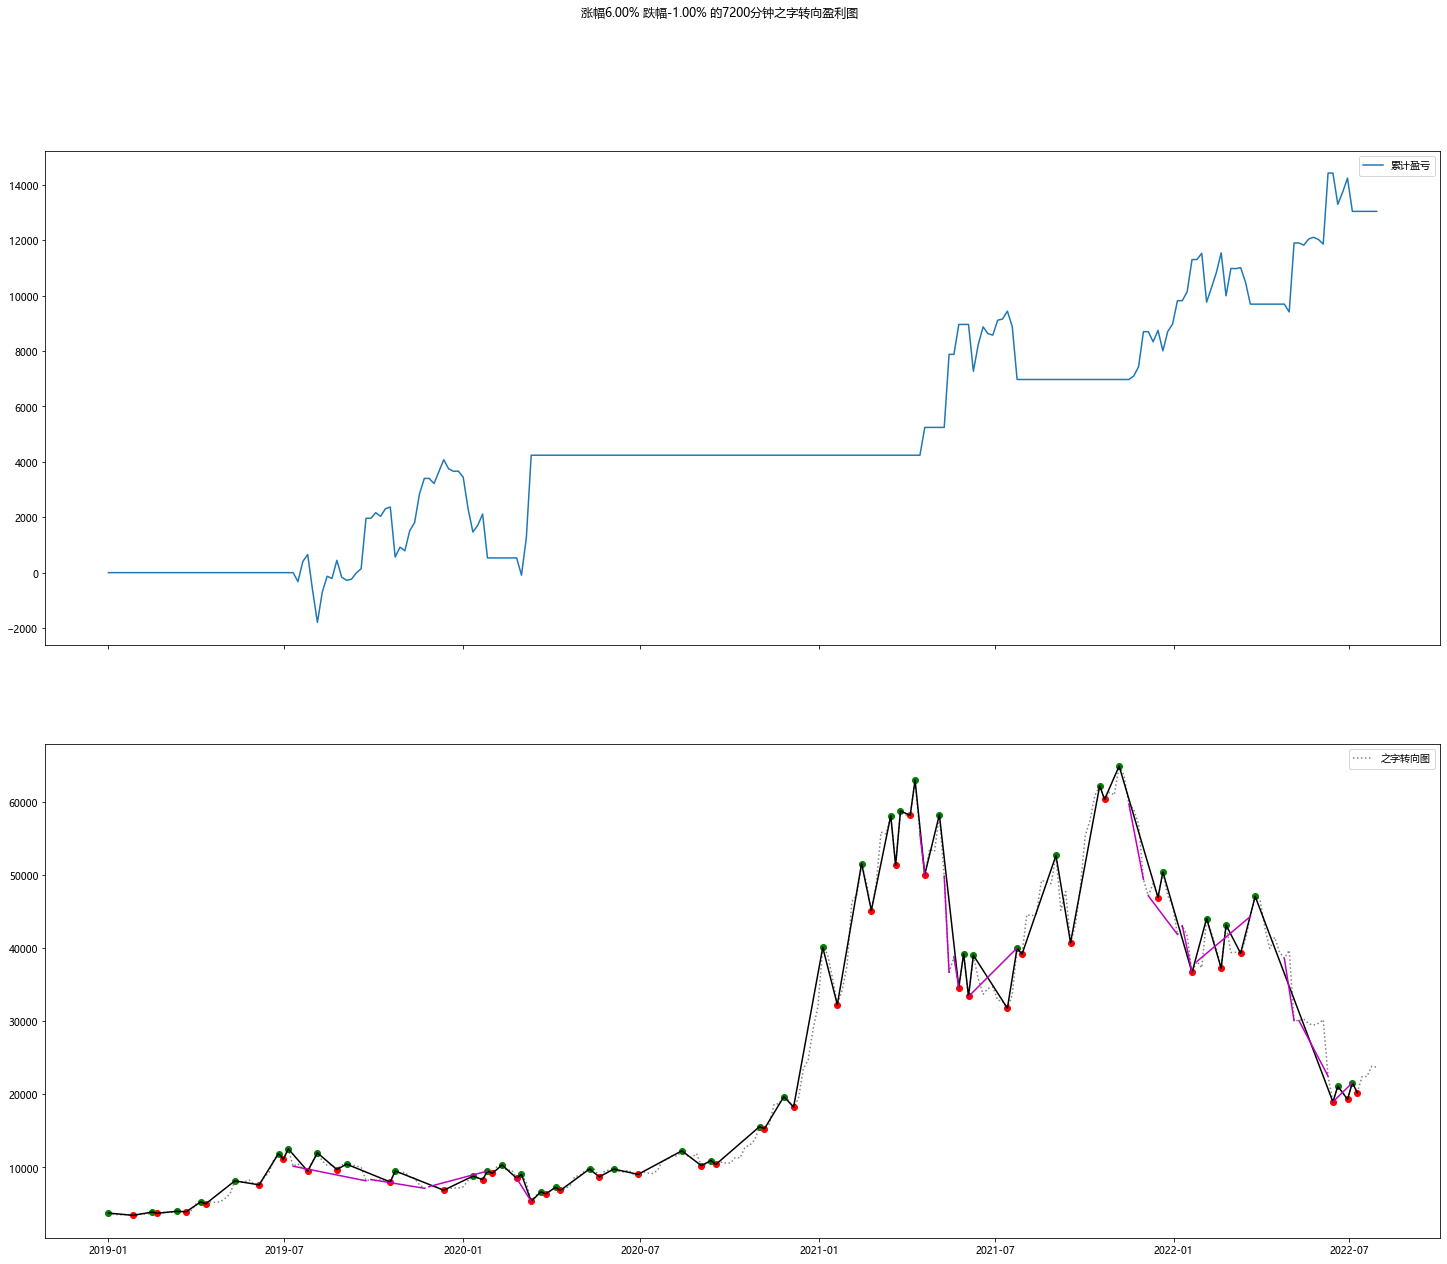

In [5]:
freq = 7200
rise = 0.06
down = -0.01
take_profit = 0.9
start_date = "2019"
data = df.resample(f'{freq}T').last()
X = data["Close"].loc[start_date:]
df_pnl, pivots, actions, stats = backtest(X, rise, down, take_profit, True)

display(pd.DataFrame([stats]))
## 绘图
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(25, 20), sharex=True)
ax1.plot(df_pnl[["pnl"]])
ax1.legend(["累计盈亏"])
ax2.plot(X, 'k:', alpha=0.5)
ax2.plot(X[pivots != 0], 'k-')
ax2.scatter(X[pivots == 1].index, X[pivots == 1], color='g')
ax2.scatter(X[pivots == -1].index, X[pivots == -1], color='r')
for i in range(len(X[actions != 0]) // 2):
    ax2.plot(X[actions != 0][i*2:i*2+2], 'm-')
# ax2.scatter(X[actions == -1].index, X[actions == -1], color='b', s=100)
# ax2.scatter(X[actions == -2].index, X[actions == -2], color='purple', s=100)
# plot_pivots(X, pivots, ax=ax2)
fig.suptitle(f"涨幅{rise:.2%} 跌幅{down:.2%} 的{freq}分钟之字转向盈利图")
ax2.legend(["之字转向图"])

## 参数2

做空 10681.52 2019-07-14 00:00:00
止盈 10174.18 2019-07-14 12:00:00 盈亏 474.9698544776402
做空 10298.05 2019-07-15 00:00:00
止盈 9439.59 2019-07-16 12:00:00 盈亏 833.6141308305941
做空 9157.02 2019-07-17 00:00:00
止损 10743.92 2019-08-03 00:00:00 盈亏 -1732.9873692533147
做空 9467.76 2019-08-29 00:00:00
止盈 8493.14 2019-09-24 12:00:00 盈亏 1029.409279491665
做空 8326.64 2019-09-25 00:00:00
止盈 8063.73 2019-09-26 12:00:00 盈亏 315.74560687144003
做空 7987.65 2019-09-27 00:00:00
止盈 7941.91 2019-10-06 00:00:00 盈亏 57.26340037432783
做空 7854.25 2019-10-06 12:00:00
止盈 7466.62 2019-10-23 12:00:00 盈亏 493.52898112486946
做空 7421.83 2019-10-24 00:00:00
止盈 7412.41 2019-10-24 12:00:00 盈亏 12.69228748165915
做空 7581.1 2019-10-25 00:00:00
止盈 7106.71 2019-11-22 00:00:00 盈亏 625.7535186186706
做空 7268.23 2019-11-22 12:00:00
止盈 7171.92 2019-11-23 00:00:00 盈亏 132.50818975183756
做空 7311.57 2019-11-23 12:00:00
止盈 7203.04 2019-11-24 00:00:00 盈亏 148.43597202789533
做空 6903.28 2019-11-24 12:00:00
止盈 6879.02 2019-11-25 00:00:00 盈亏 35.1427147674

,rise,down,freq,take_profit,total_return,yearly_vol,maxdrawdown,sharpe,hold_time,start_date,end_date
0,0.13,-0.06,720.0,1,0.948356,0.447752,0.448787,2.002806,1.057534,2019-01-01,2022-07-31


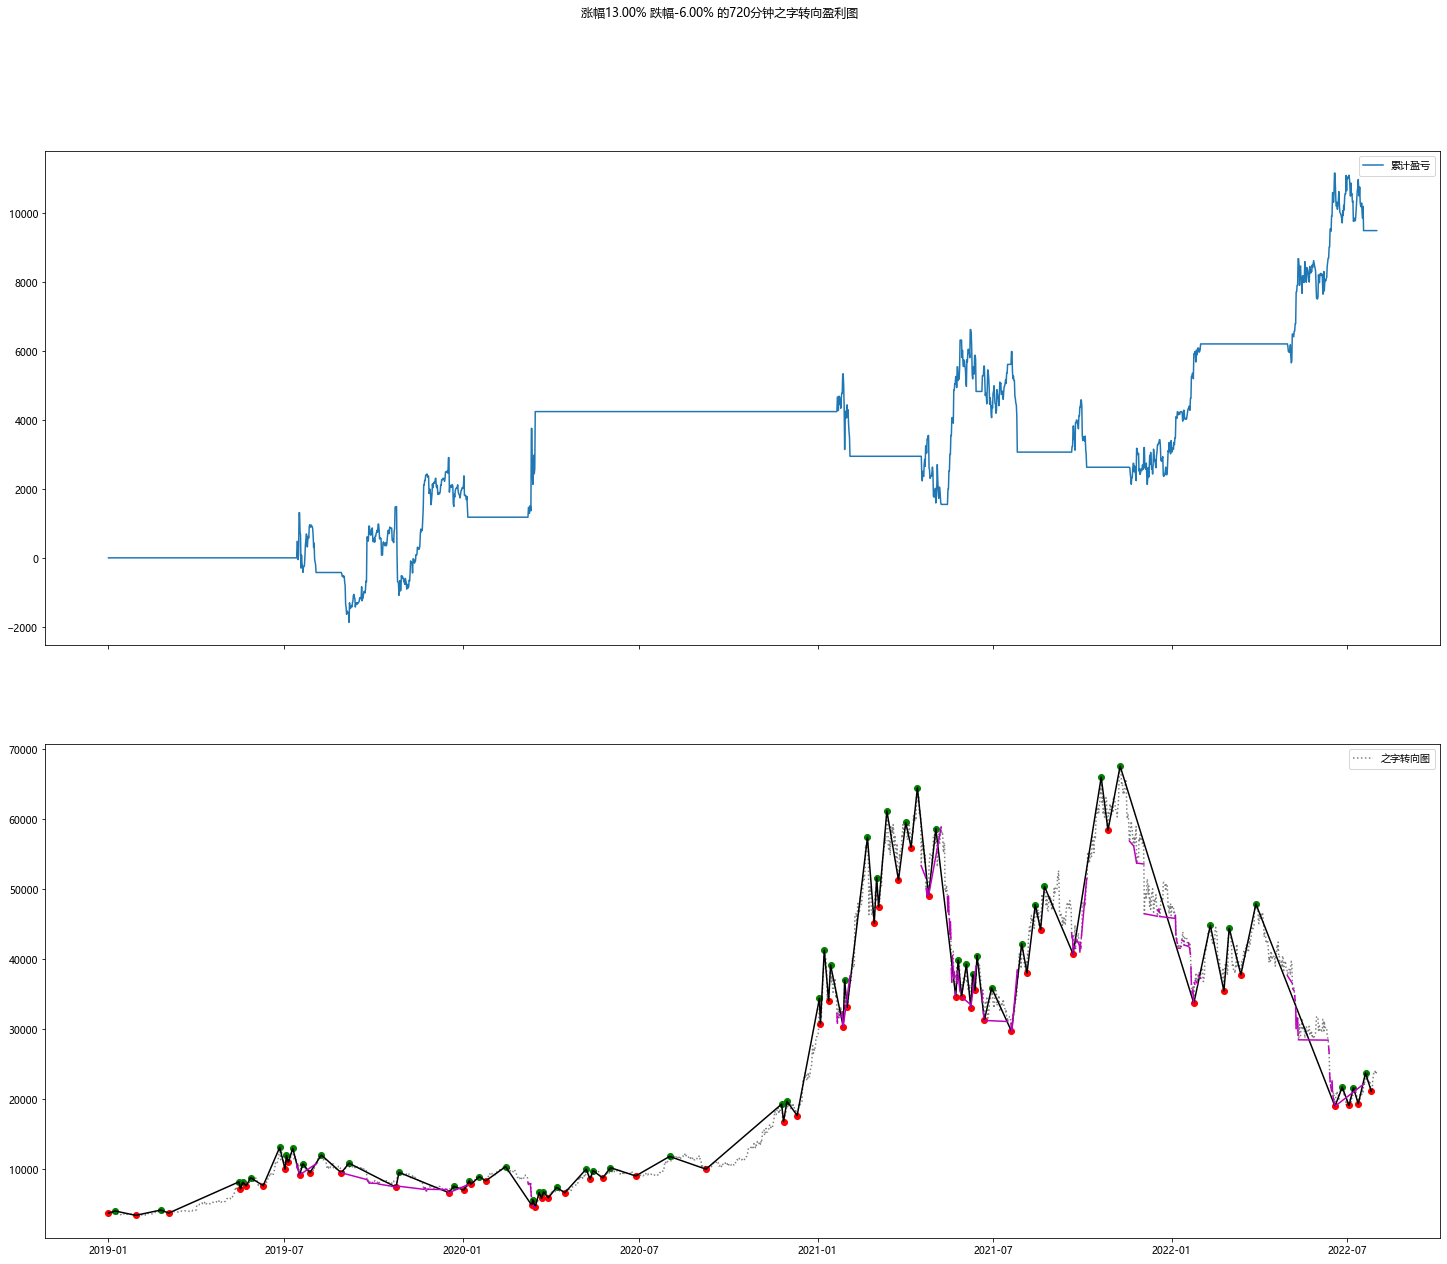

In [6]:
rise = 0.13
down = -0.06
freq = 720
take_profit = 1
start_date = "2019"
data = df.resample(f'{freq}T').last().fillna(method='ffill')
X = data["Close"].loc[start_date:]
df_pnl, pivots, actions, stats = backtest(X, rise, down, take_profit, True)

display(pd.DataFrame([stats]))
## 绘图
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(25, 20), sharex=True)
ax1.plot(df_pnl[["pnl"]])
ax1.legend(["累计盈亏"])
ax2.plot(X, 'k:', alpha=0.5)
ax2.plot(X[pivots != 0], 'k-')
ax2.scatter(X[pivots == 1].index, X[pivots == 1], color='g')
ax2.scatter(X[pivots == -1].index, X[pivots == -1], color='r')
for i in range(len(X[actions != 0]) // 2):
    ax2.plot(X[actions != 0][i*2:i*2+2], 'm-')
# ax2.scatter(X[actions == -1].index, X[actions == -1], color='b', s=100)
# ax2.scatter(X[actions == -2].index, X[actions == -2], color='purple', s=100)
# plot_pivots(X, pivots, ax=ax2)
fig.suptitle(f"涨幅{rise:.2%} 跌幅{down:.2%} 的{freq}分钟之字转向盈利图")
ax2.legend(["之字转向图"])

In [7]:
def safe_arange(start, stop, step):
    return step * np.arange(start / step, stop / step)
safe_arange(0.6, 1, 0.05)

array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

# 做多

In [8]:
# TODO: 加上均线
def backtest_long(X, rise, down, take_profit=0, output=True):
    # pivots = peak_valley_pivots(X, rise, -rise)
    allowance = 10000
    cash = 0
    shares = 0
    low = None
    high = None
    n = len(X)
    cash_array = np.zeros(n)
    shares_array = np.zeros(n)
    actions = np.zeros(n)
    up_thresh, down_thresh = rise, down
    last_buy = 1000000
    last_sell = 1000000
    for i in range(n):
        if i == 0:
            initial_pivot = identify_initial_pivot(X[:100], up_thresh, down_thresh) # 这个会数据泄漏
            t_n = len(X)
            pivots = np.zeros(t_n, dtype=np.int_)
            trend = -initial_pivot
            last_pivot_t = 0
            last_pivot_x = X[0]

            pivots[0] = initial_pivot
            up_thresh += 1
            down_thresh += 1
            continue
        
        t = i
        x = X[t]
        r = x / last_pivot_x

        if trend == -1:
            if r >= up_thresh: # 如果上升幅度超过阈值，则标记上个点为谷底
                pivots[last_pivot_t] = trend # 上一个被标记为谷底的点
                low = last_pivot_x
                trend = PEAK
                last_pivot_x = x
                last_pivot_t = t
            elif x < last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t
        else:
            if r <= down_thresh: # 如果下降幅度超过阈值，则标记上个点为顶点
                pivots[last_pivot_t] = trend
                high = last_pivot_x
                trend = VALLEY
                last_pivot_x = x
                last_pivot_t = t
            elif x > last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t   
                
        # if last_pivot_t == t_n-1:
        #     pivots[last_pivot_t] = trend # 新趋势
        # elif pivots[t_n-1] == 0:
        #     pivots[t_n-1] = -trend # 老趋势
            
        p = X[i] # 当前价格
        
        # if pivots[i] == -1:
        #     low = p
            
        # if pivots[i] == 1:
        #     high = p
            
        if low is None or high is None: # 确保已经有了low high
            continue

        # if p < low and shares >= 0: # and p < high * (1-rise) # TODO: 增加频率，避免一下子跌太多，错过做空时机
        if p > high and shares <= 0:
            # 做多
            shares = allowance / p
            cash -= allowance
            if output: print("做多", p, X.index[i])
            actions[i] = 1
            last_buy = p
            
        # if (p > high) and shares < 0: # and p > low * (1 + rise)
        if (p < low) and shares > 0:
        # if (p > (0.5 * low + 0.5 * high)) and shares < 0: # 特殊止损条件
            # 平仓止损
            cash += shares * p
            if output: print("止损", p, X.index[i], "盈亏", allowance + shares * p)
            shares = 0
            actions[i] = 2
            last_sell = p
        
        if (p > take_profit * last_buy) and shares > 0:
            # 止盈
            cash += shares * p
            if output: print("止盈", p, X.index[i], "盈亏", allowance + shares * p)
            shares = 0
            actions[i] = 3
            last_sell = p
            
        if i == len(pivots) - 1: # 最后时刻清仓
            cash += shares * p
            shares = 0
        
        cash_array[i] = cash
        shares_array[i] = shares
    
    ## 计算收益
    df_pnl = pd.DataFrame({"cash": cash_array, "shares": shares_array, "price": X, "pivots": pivots, "actions": actions})
    df_pnl.index = X.index
    df_pnl["pnl"] = df_pnl["cash"] + df_pnl["shares"] * df_pnl["price"]
    
    # 计算收益率等参数
    df_pnl["ret"] = df_pnl["pnl"].diff().fillna(0) / allowance
    freq = (df_pnl.index[1] - df_pnl.index[0]).total_seconds() // 60
    rets = df_pnl.loc[df_pnl["ret"] != 0, "ret"]
    if len(rets) == 0:
        stats = {}
    else:
        time_length = rets.shape[0] * ((df_pnl.index[1] - df_pnl.index[0]).total_seconds() / 3600 / 24 / 365)
        total_return = df_pnl["pnl"][-1] / allowance
        yearly_return = total_return / time_length
        yearly_vol = df_pnl["ret"].std() * np.sqrt(60 / freq * 24 * 365)
        maxdrawdown = max(rets.cumsum().cummax() - rets.cumsum())
        sharpe = yearly_return / yearly_vol
        stats = dict(rise=rise, down=down, freq=freq, take_profit=take_profit, total_return=total_return, yearly_vol=yearly_vol, maxdrawdown=maxdrawdown, sharpe=sharpe, hold_time=time_length, start_date=X.index[0].date(), end_date=X.index[-1].date())
    # stats = [rise, total_return, yearly_vol, maxdrawdown]
    return df_pnl, pivots, actions, stats

## 参数1

做空 3434.15 2019-01-28 00:00:00
止盈 3411.04 2019-01-29 00:00:00 盈亏 67.29467262641447
做空 3405.37 2019-02-06 00:00:00
止盈 3398.4 2019-02-07 00:00:00 盈亏 20.46767311628355
做空 3715.3 2019-03-04 00:00:00
止损 4144.56 2019-04-01 00:00:00 盈亏 -1155.3844911581837
做空 8115.82 2019-06-03 00:00:00
止盈 7687.03 2019-06-04 00:00:00 盈亏 528.3384796607133
做空 7628.13 2019-06-09 00:00:00
止损 7982.75 2019-06-10 00:00:00 盈亏 -464.8845785271096
做空 10854.1 2019-06-30 00:00:00
止盈 10624.93 2019-07-01 00:00:00 盈亏 211.13680544678937
做空 10174.18 2019-07-14 00:00:00
止盈 9439.59 2019-07-16 00:00:00 盈亏 722.0139608302579
做空 9476.52 2019-07-27 00:00:00
止损 10080.53 2019-07-31 00:00:00 盈亏 -637.3753234309643
做空 10892.71 2019-08-13 00:00:00
止盈 10050.37 2019-08-14 00:00:00 盈亏 773.3061836769721
做空 9721.0 2019-08-28 00:00:00
止盈 9498.44 2019-08-29 00:00:00 盈亏 228.94763913177485
做空 9584.54 2019-08-30 00:00:00
止损 10615.28 2019-09-03 00:00:00 盈亏 -1075.4193732823896
做空 9986.39 2019-09-21 00:00:00
止盈 9702.25 2019-09-23 00:00:00 盈亏 284.5272415

,rise,down,freq,take_profit,total_return,yearly_vol,maxdrawdown,sharpe,hold_time,start_date,end_date
0,0.01,-0.04,1440.0,1,1.496243,0.406858,0.206939,3.890744,0.945205,2019-01-01,2022-07-31


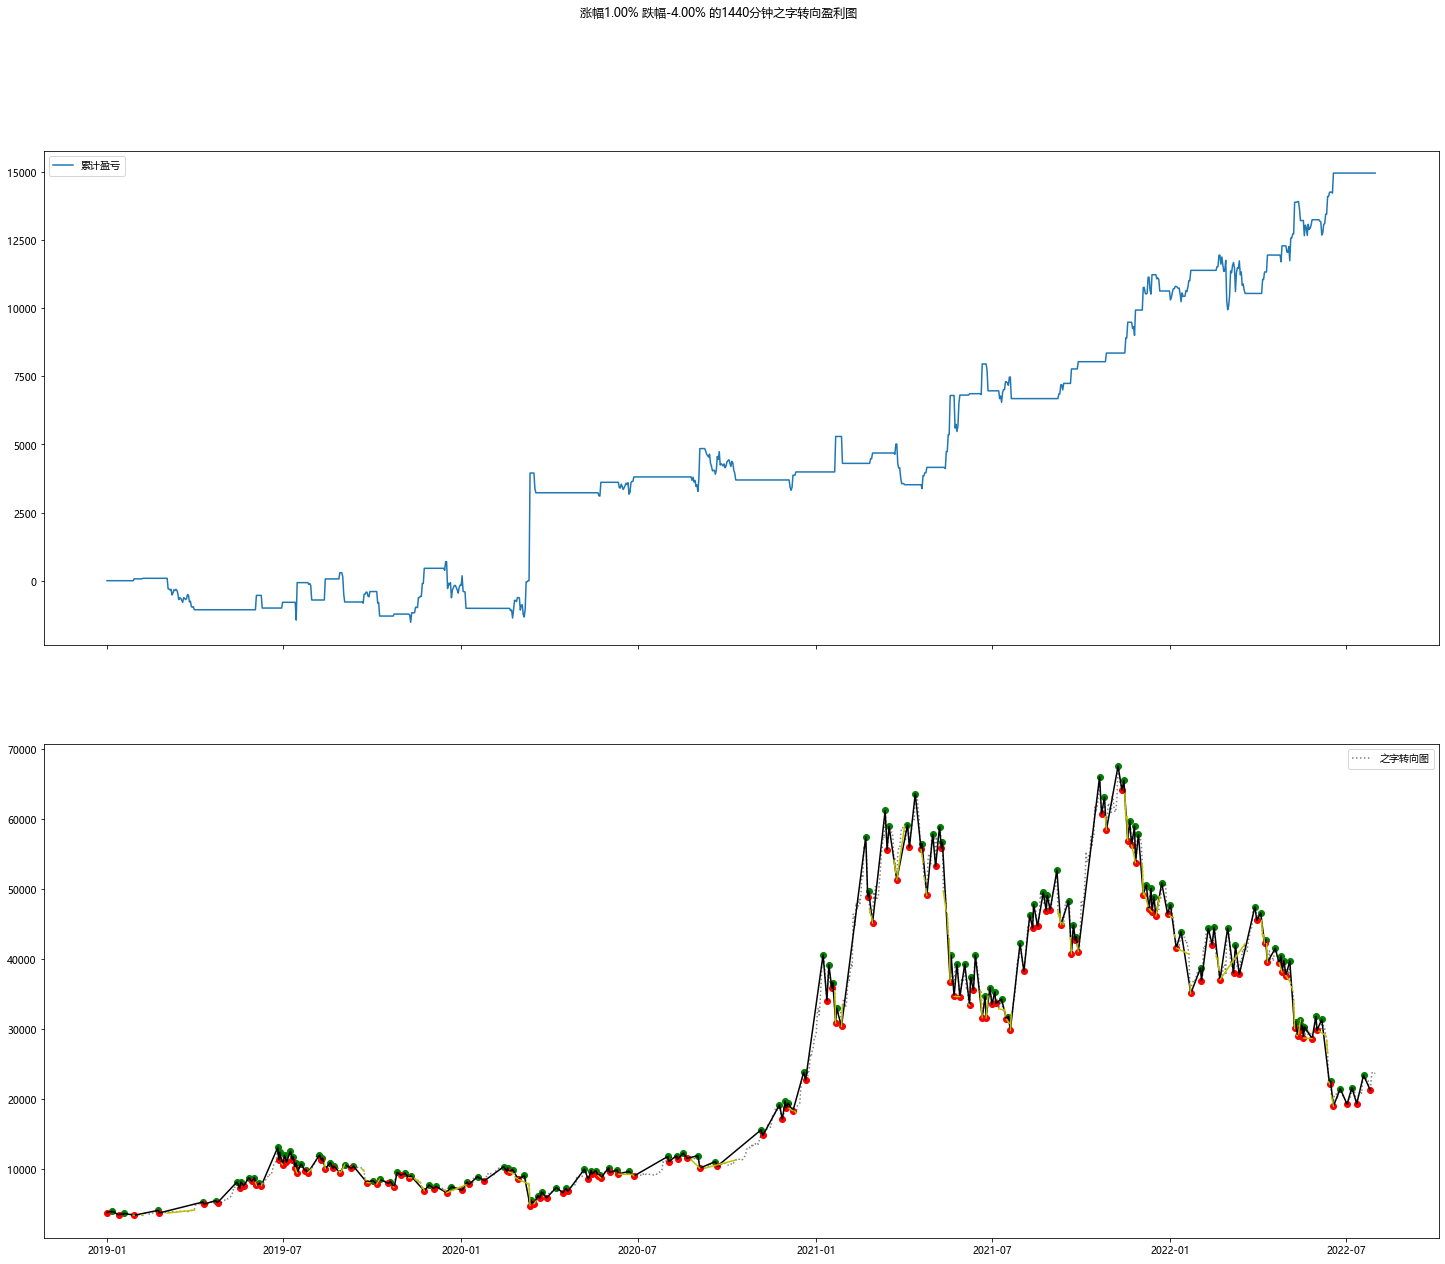

In [9]:
freq = 1440
rise = 0.01
down = -0.04
take_profit = 1
start_date = "2019"
data = df.resample(f'{freq}T').last()
X = data["Close"].loc[start_date:]
df_pnl, pivots, actions, stats = backtest(X, rise, down, take_profit, True)

display(pd.DataFrame([stats]))
## 绘图
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(25, 20), sharex=True)
ax1.plot(df_pnl[["pnl"]])
ax1.legend(["累计盈亏"])
ax2.plot(X, 'k:', alpha=0.5)
ax2.plot(X[pivots != 0], 'k-')
ax2.scatter(X[pivots == 1].index, X[pivots == 1], color='g')
ax2.scatter(X[pivots == -1].index, X[pivots == -1], color='r')
for i in range(len(X[actions != 0]) // 2):
    ax2.plot(X[actions != 0][i*2:i*2+2], 'y-')
# ax2.scatter(X[actions == -1].index, X[actions == -1], color='b', s=100)
# ax2.scatter(X[actions == -2].index, X[actions == -2], color='purple', s=100)
# plot_pivots(X, pivots, ax=ax2)
fig.suptitle(f"涨幅{rise:.2%} 跌幅{down:.2%} 的{freq}分钟之字转向盈利图")
ax2.legend(["之字转向图"])

## 参数2

做空 3427.57 2019-01-28 00:00:00
止盈 3427.57 2019-01-28 00:00:00 盈亏 0.0
做空 3434.15 2019-01-28 12:00:00
止盈 3434.15 2019-01-28 12:00:00 盈亏 0.0
做空 3385.32 2019-01-29 00:00:00
止盈 3385.32 2019-01-29 00:00:00 盈亏 0.0
做空 3411.04 2019-01-29 12:00:00
止盈 3411.04 2019-01-29 12:00:00 盈亏 0.0
做空 3429.25 2019-01-30 00:00:00
止盈 3429.25 2019-01-30 00:00:00 盈亏 0.0
做空 3707.6 2019-03-04 00:00:00
止盈 3707.6 2019-03-04 00:00:00 盈亏 0.0
做空 3715.3 2019-03-04 12:00:00
止盈 3715.3 2019-03-04 12:00:00 盈亏 0.0
做空 3739.57 2019-03-05 00:00:00
止盈 3739.57 2019-03-05 00:00:00 盈亏 0.0
做空 8115.82 2019-06-03 12:00:00
止盈 8115.82 2019-06-03 12:00:00 盈亏 0.0
做空 7943.56 2019-06-04 00:00:00
止盈 7943.56 2019-06-04 00:00:00 盈亏 0.0
做空 7687.03 2019-06-04 12:00:00
止盈 7687.03 2019-06-04 12:00:00 盈亏 0.0
做空 7791.35 2019-06-05 00:00:00
止盈 7791.35 2019-06-05 00:00:00 盈亏 0.0
做空 7776.5 2019-06-05 12:00:00
止盈 7776.5 2019-06-05 12:00:00 盈亏 0.0
做空 7831.51 2019-06-06 00:00:00
止盈 7831.51 2019-06-06 00:00:00 盈亏 0.0
做空 7786.7 2019-06-06 12:00:00
止盈 7786.7 

,rise,down,freq,take_profit,total_return,yearly_vol,maxdrawdown,sharpe,hold_time,start_date,end_date
0,0.02,-0.05,720.0,1.1,1.818989e-16,3.465142e-16,5.456968e-16,29.477363,0.017808,2019-01-01,2022-07-31


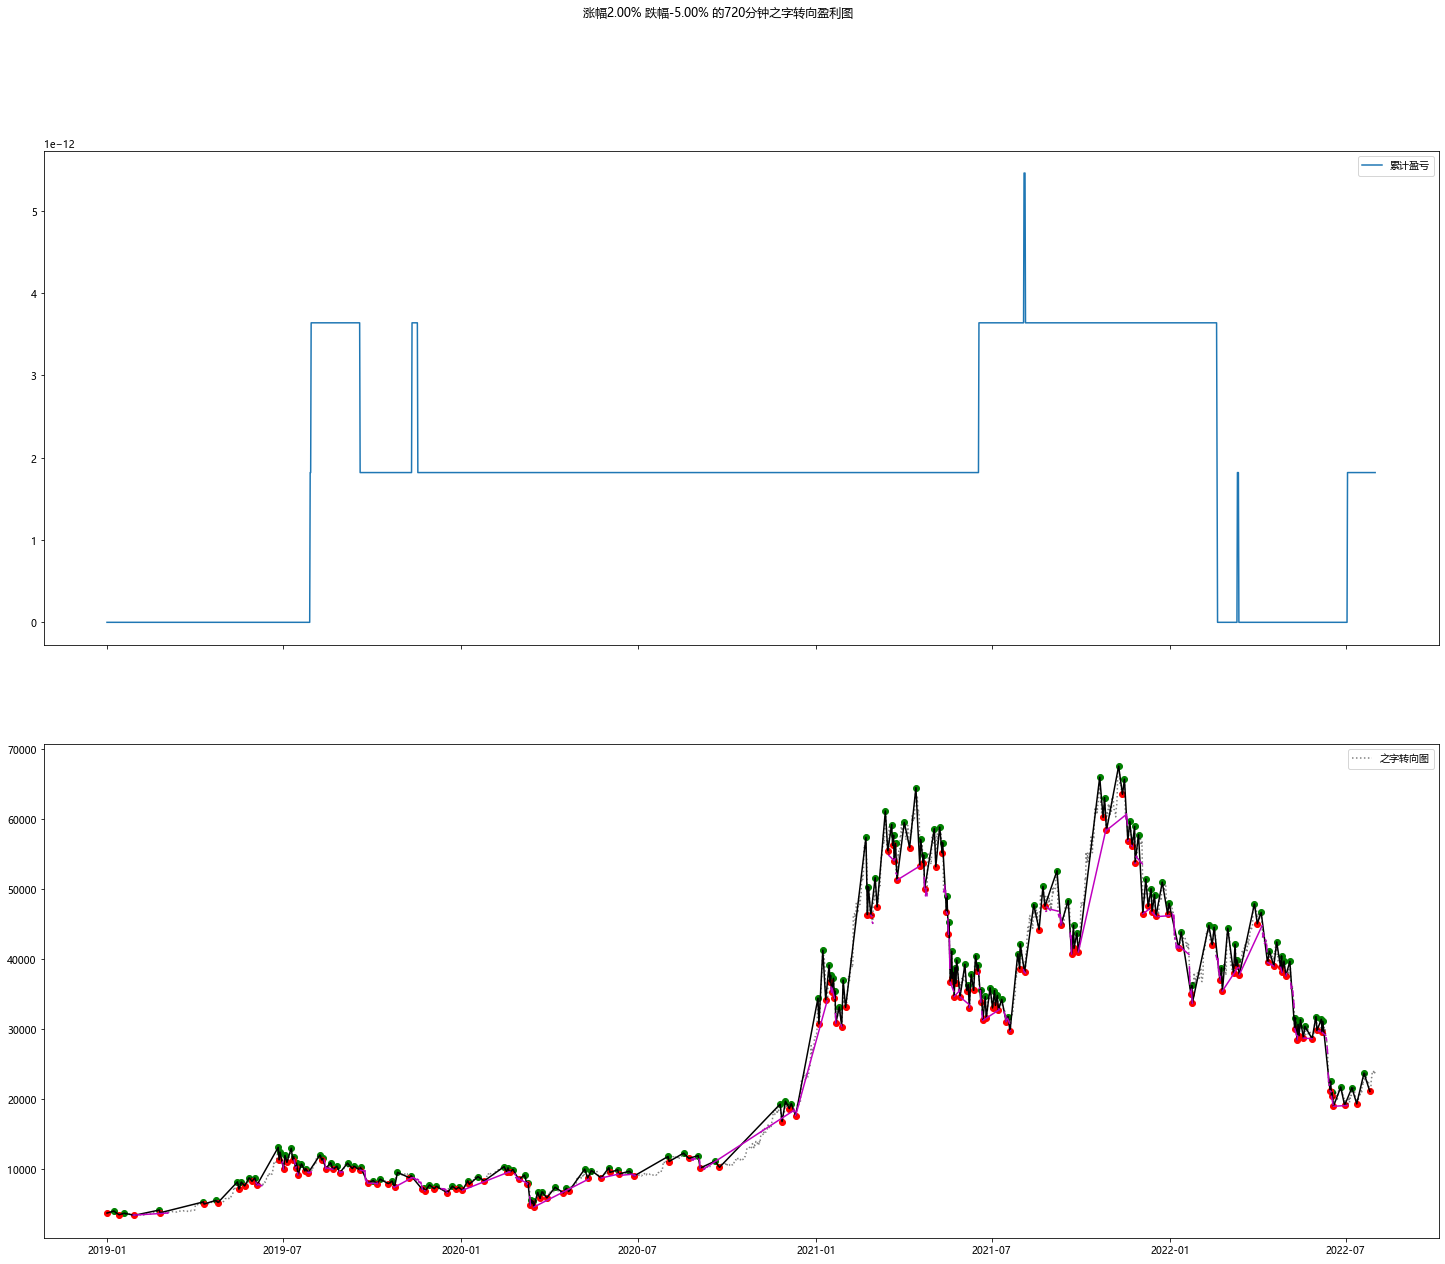

In [10]:
# freq = 7200
# rise = 0.05
# down = -0.01
# take_profit = 1

rise, down, freq, take_profit = 0.02, -0.05, 720, 1.1
start_date = "2019"
data = df.resample(f'{freq}T').last()
X = data["Close"].loc[start_date:]
df_pnl, pivots, actions, stats = backtest(X, rise, down, take_profit, True)

display(pd.DataFrame([stats]))
## 绘图
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(25, 20), sharex=True)
ax1.plot(df_pnl[["pnl"]])
ax1.legend(["累计盈亏"])
ax2.plot(X, 'k:', alpha=0.5)
ax2.plot(X[pivots != 0], 'k-')
ax2.scatter(X[pivots == 1].index, X[pivots == 1], color='g')
ax2.scatter(X[pivots == -1].index, X[pivots == -1], color='r')
for i in range(len(X[actions != 0]) // 2):
    ax2.plot(X[actions != 0][i*2:i*2+2], 'm-')
# ax2.scatter(X[actions == -1].index, X[actions == -1], color='b', s=100)
# ax2.scatter(X[actions == -2].index, X[actions == -2], color='purple', s=100)
# plot_pivots(X, pivots, ax=ax2)
fig.suptitle(f"涨幅{rise:.2%} 跌幅{down:.2%} 的{freq}分钟之字转向盈利图")
ax2.legend(["之字转向图"])

# 结合做多做空

In [11]:
# # TODO: 加上均线
# # 可能需要两套体系来存放

# def backtest_both(X, rise, down, take_profit_long=10, take_profit_short=0, output=True):
#     # pivots = peak_valley_pivots(X, rise, -rise)
#     allowance = 10000
#     cash = 0
#     shares = 0
#     low = None
#     high = None
#     n = len(X)
#     cash_array = np.zeros(n)
#     shares_array = np.zeros(n)
#     actions = np.zeros(n)
#     up_thresh, down_thresh = rise, down
#     last_buy = 1000000
#     last_sell = 1000000
#     for i in range(n):
#         if i == 0:
#             initial_pivot = identify_initial_pivot(X[:100], up_thresh, down_thresh) # 这个会数据泄漏
#             t_n = len(X)
#             pivots = np.zeros(t_n, dtype=np.int_)
#             trend = -initial_pivot
#             last_pivot_t = 0
#             last_pivot_x = X[0]

#             pivots[0] = initial_pivot
#             up_thresh += 1
#             down_thresh += 1
#             continue
        
#         t = i
#         x = X[t]
#         r = x / last_pivot_x

#         if trend == -1:
#             if r >= up_thresh: # 如果上升幅度超过阈值，则标记上个点为谷底
#                 pivots[last_pivot_t] = trend # 上一个被标记为谷底的点
#                 low = last_pivot_x
#                 trend = PEAK
#                 last_pivot_x = x
#                 last_pivot_t = t
#             elif x < last_pivot_x:
#                 last_pivot_x = x
#                 last_pivot_t = t
#         else:
#             if r <= down_thresh: # 如果下降幅度超过阈值，则标记上个点为顶点
#                 pivots[last_pivot_t] = trend
#                 high = last_pivot_x
#                 trend = VALLEY
#                 last_pivot_x = x
#                 last_pivot_t = t
#             elif x > last_pivot_x:
#                 last_pivot_x = x
#                 last_pivot_t = t   
            
#         p = X[i] # 当前价格
            
#         if low is None or high is None: # 确保已经有了low high
#             continue
        
#         if (p < low) and shares > 0: # 如果当前价格小于谷底，并且有持仓，则卖出止损
#             # 平仓止损
#             cash += shares * p
#             if output: print("止损", p, X.index[i], "盈亏", allowance + shares * p)
#             shares = 0
#             actions[i] = 2
#             last_sell = p
        
#         # if (p > take_profit_long * last_buy) and shares > 0: # 如果当前价格大于买入价格的止盈，并且有持仓，则卖出止盈
#         #     # 止盈
#         #     cash += shares * p
#         #     if output: print("止盈", p, X.index[i], "盈亏", allowance + shares * p)
#         #     shares = 0
#         #     actions[i] = 3
#         #     last_sell = p
        
#         if (p > high) and shares < 0: # 如果当前价格大于顶点，并且有持仓，则买入止损
#             # 平仓止损
#             cash += shares * p
#             if output: print("止损", p, X.index[i], "盈亏", allowance + shares * p)
#             shares = 0
#             actions[i] = -2
#             last_buy = p
        
#         # if (p < take_profit_short * last_sell) and shares < 0: # 如果当前价格小于卖出价格的止盈，并且有做空，则买入止盈
#         #     # 止盈
#         #     cash += shares * p
#         #     if output: print("止盈", p, X.index[i], "盈亏", allowance + shares * p)
#         #     shares = 0
#         #     actions[i] = -3
#         #     last_buy = p
            
#         if p > high and shares <= 0: # 如果当前价格大于顶点，并且没有持仓，则做多
#             # 做多
#             shares = allowance / p
#             cash -= allowance
#             if output: print("做多", p, X.index[i])
#             actions[i] = 1
#             last_buy = p
        
#         if p < low and shares >= 0: # 如果当前价格小于谷底，并且没有持仓，则做空
#             # 做空
#             shares = -allowance / p
#             cash += allowance
#             if output: print("做空", p, X.index[i])
#             actions[i] = -1
#             last_sell = p
            
#         if i == len(pivots) - 1: # 最后时刻清仓
#             cash += shares * p
#             shares = 0
        
#         cash_array[i] = cash
#         shares_array[i] = shares
        
#     if last_pivot_t == t_n-1:
#         pivots[last_pivot_t] = trend # 新趋势
#     elif pivots[t_n-1] == 0:
#         pivots[t_n-1] = -trend # 老趋势
    
#     ## 计算收益
#     df_pnl = pd.DataFrame({"cash": cash_array, "shares": shares_array, "price": X, "pivots": pivots, "actions": actions})
#     df_pnl.index = X.index
#     df_pnl["pnl"] = df_pnl["cash"] + df_pnl["shares"] * df_pnl["price"]
    
#     # 计算收益率等参数
#     df_pnl["ret"] = df_pnl["pnl"].diff().fillna(0) / allowance
#     freq = (df_pnl.index[1] - df_pnl.index[0]).total_seconds() // 60
#     rets = df_pnl.loc[df_pnl["ret"] != 0, "ret"]
#     if len(rets) == 0:
#         stats = {}
#     else:
#         time_length = rets.shape[0] * ((df_pnl.index[1] - df_pnl.index[0]).total_seconds() / 3600 / 24 / 365)
#         total_return = df_pnl["pnl"][-1] / allowance
#         yearly_return = total_return / time_length
#         yearly_vol = df_pnl["ret"].std() * np.sqrt(60 / freq * 24 * 365)
#         maxdrawdown = max(rets.cumsum().cummax() - rets.cumsum())
#         sharpe = yearly_return / yearly_vol
#         stats = dict(rise=rise, down=down, freq=freq, take_profit_long=take_profit_long, take_profit_short=take_profit_short, total_return=total_return, yearly_vol=yearly_vol, maxdrawdown=maxdrawdown, sharpe=sharpe, hold_time=time_length, start_date=X.index[0].date(), end_date=X.index[-1].date())
#     # stats = [rise, total_return, yearly_vol, maxdrawdown]
#     return df_pnl, pivots, actions, stats

In [12]:
import zigzag

PEAK = 1
VALLEY = -1


def identify_initial_pivot(X, up_thresh, down_thresh):
    x_0 = X[0]
    x_t = x_0

    max_x = x_0
    min_x = x_0

    max_t = 0
    min_t = 0

    up_thresh += 1
    down_thresh += 1

    for t in range(1, len(X)):
        x_t = X[t]

        if x_t / min_x >= up_thresh:
            return VALLEY if min_t == 0 else PEAK

        if x_t / max_x <= down_thresh:
            return PEAK if max_t == 0 else VALLEY

        if x_t > max_x:
            max_x = x_t
            max_t = t

        if x_t < min_x:
            min_x = x_t
            min_t = t

    t_n = len(X)-1
    return VALLEY if x_0 < X[t_n] else PEAK


def backtest_both(X, rise, down, take_profit_long=10, take_profit_short=0, output=True, mode=0, ma=None, ma_window=0):
    # pivots = peak_valley_pivots(X, rise, -rise)
    allowance = 1
    cash = 0
    shares_long = 0
    shares_short = 0
    low = None
    high = None
    n = len(X)
    cash_array = np.zeros(n)
    shares_long_array = np.zeros(n)
    shares_short_array = np.zeros(n)
    actions_long = np.zeros(n)
    actions_short = np.zeros(n)
    cum_returns = np.zeros(n)
    up_thresh, down_thresh = rise, down
    last_buy = 1000000
    last_sell = 1000000
    last_price = 0
    
    for i in range(n):
        if i == 0:
            initial_pivot = identify_initial_pivot(X[:100], up_thresh, down_thresh) # 这个会数据泄漏
            t_n = len(X)
            pivots = np.zeros(t_n, dtype=np.int_)
            trend = -initial_pivot
            last_pivot_t = 0
            last_pivot_x = X[0]

            pivots[0] = initial_pivot
            up_thresh += 1
            down_thresh += 1
            last_price = X[i]
            continue
        
        t = i
        x = X[t]
        r = x / last_pivot_x

        if trend == -1:
            if r >= up_thresh: # 如果上升幅度超过阈值，则标记上个点为谷底
                pivots[last_pivot_t] = trend # 上一个被标记为谷底的点
                low = last_pivot_x
                trend = PEAK
                last_pivot_x = x
                last_pivot_t = t
            elif x < last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t
        else:
            if r <= down_thresh: # 如果下降幅度超过阈值，则标记上个点为顶点
                pivots[last_pivot_t] = trend
                high = last_pivot_x
                trend = VALLEY
                last_pivot_x = x
                last_pivot_t = t
            elif x > last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t   
            
        p = X[i] # 当前价格
            
        if low is None or high is None: # 确保已经有了low high
            continue
        
        ## 计算收益率
        cur_return = 0 
        if shares_long > 0:        
            cur_return += (p - last_price) / last_buy
        if shares_short < 0:
            cur_return += (last_price - p) / last_sell
        cum_returns[i] = cur_return + cum_returns[i - 1]
        last_price = p
        
        if mode >= 0 and (p < low) and shares_long > 0: # 如果当前价格小于谷底，并且有持仓，则卖出止损
            # 平仓止损
            # cash += shares_long * p
            cash += shares_long * low
            if output: print("止损", p, X.index[i], "盈亏", p - last_buy)
            shares_long = 0
            actions_long[i] = 2
            last_sell = p
        
        # if (p > take_profit_long * last_buy) and shares > 0: # 如果当前价格大于买入价格的止盈，并且有持仓，则卖出止盈
        #     # 止盈
        #     cash += shares * p
        #     if output: print("止盈", p, X.index[i], "盈亏", allowance + shares * p)
        #     shares = 0
        #     actions[i] = 3
        #     last_sell = p
        
        if mode <= 0 and (p > high) and shares_short < 0: # 如果当前价格大于顶点，并且有做空持仓，则买入止损
            # 平仓止损
            # cash += shares_short * p
            cash += shares_short * high
            if output: print("止损", p, X.index[i], "盈亏", last_sell - p)
            shares_short = 0
            actions_short[i] = -2
            last_buy = p


            
        
        # if (p < take_profit_short * last_sell) and shares < 0: # 如果当前价格小于卖出价格的止盈，并且有做空，则买入止盈
        #     # 止盈
        #     cash += shares * p
        #     if output: print("止盈", p, X.index[i], "盈亏", allowance + shares * p)
        #     shares = 0
        #     actions[i] = -3
        #     last_buy = p
            
        if mode >= 0 and p > high and shares_long == 0 and (ma is None or p > ma[i] or np.isnan(ma[i])): # 如果当前价格大于顶点，并且没有持仓，则做多
            # 做多
            shares_long = allowance
            # cash -= shares_long * p
            cash -= shares_long * high
            if output: print("做多", p, X.index[i])
            actions_long[i] = 1
            last_buy = p
        
        if mode <= 0 and p < low and shares_short == 0 and (ma is None or p < ma[i] or np.isnan(ma[i])): # 如果当前价格小于谷底，并且没有持仓，则做空
            # 做空
            shares_short = -allowance
            # cash -= shares_short * p
            cash -= shares_short * low
            if output: print("做空", p, X.index[i])
            actions_short[i] = -1
            last_sell = p
            
            
        if i == len(pivots) - 1: # 最后时刻清仓
            cash += (shares_short + shares_long) * p
            shares_short = shares_long = 0
        
        cash_array[i] = cash
        shares_long_array[i] = shares_long
        shares_short_array[i] = shares_short
    
    shares_array = shares_long_array + shares_short_array
    if last_pivot_t == t_n-1:
        pivots[last_pivot_t] = trend # 新趋势
    elif pivots[t_n-1] == 0:
        pivots[t_n-1] = -trend # 老趋势
    
    ## 计算收益
    df_pnl = pd.DataFrame({"cash": cash_array, "shares": shares_array, "actions_long": actions_long, "actions_short": actions_short, "price": X, "pivots": pivots})
    df_pnl.index = X.index
    df_pnl["pnl"] = df_pnl["cash"] + df_pnl["shares"] * df_pnl["price"]
    df_pnl["cum_return"] = cum_returns
    
    # 计算收益率等参数
    df_pnl["ret"] = df_pnl["cum_return"].diff().fillna(0)
    freq = (df_pnl.index[1] - df_pnl.index[0]).total_seconds() // 60
    rets = df_pnl.loc[df_pnl["ret"] != 0, "ret"]
    if len(rets) == 0:
        stats = {}
    else:
        time_length = rets.shape[0] * ((df_pnl.index[1] - df_pnl.index[0]).total_seconds() / 3600 / 24 / 365)
        total_return = df_pnl["cum_return"][-1]
        yearly_return = total_return / time_length
        yearly_vol = df_pnl["ret"].std() * np.sqrt(60 / freq * 24 * 365)
        maxdrawdown = max(rets.cumsum().cummax() - rets.cumsum())
        sharpe = yearly_return / yearly_vol
        stats = dict(rise=rise, down=down, freq=freq, take_profit_long=take_profit_long, take_profit_short=take_profit_short, total_return=total_return, yearly_vol=yearly_vol, maxdrawdown=maxdrawdown, sharpe=sharpe, hold_time=time_length, ma_window=ma_window, start_date=X.index[0].date(), end_date=X.index[-1].date())
    # stats = [rise, total_return, yearly_vol, maxdrawdown]
    return df_pnl, stats

## 参数1

,rise,down,freq,take_profit_long,take_profit_short,total_return,yearly_vol,maxdrawdown,sharpe,hold_time,ma_window,start_date,end_date
0,0.05,-0.075,15.0,1,0.9,0.378402,0.784674,0.530758,0.697849,0.691039,200,2021-01-01,2021-12-31


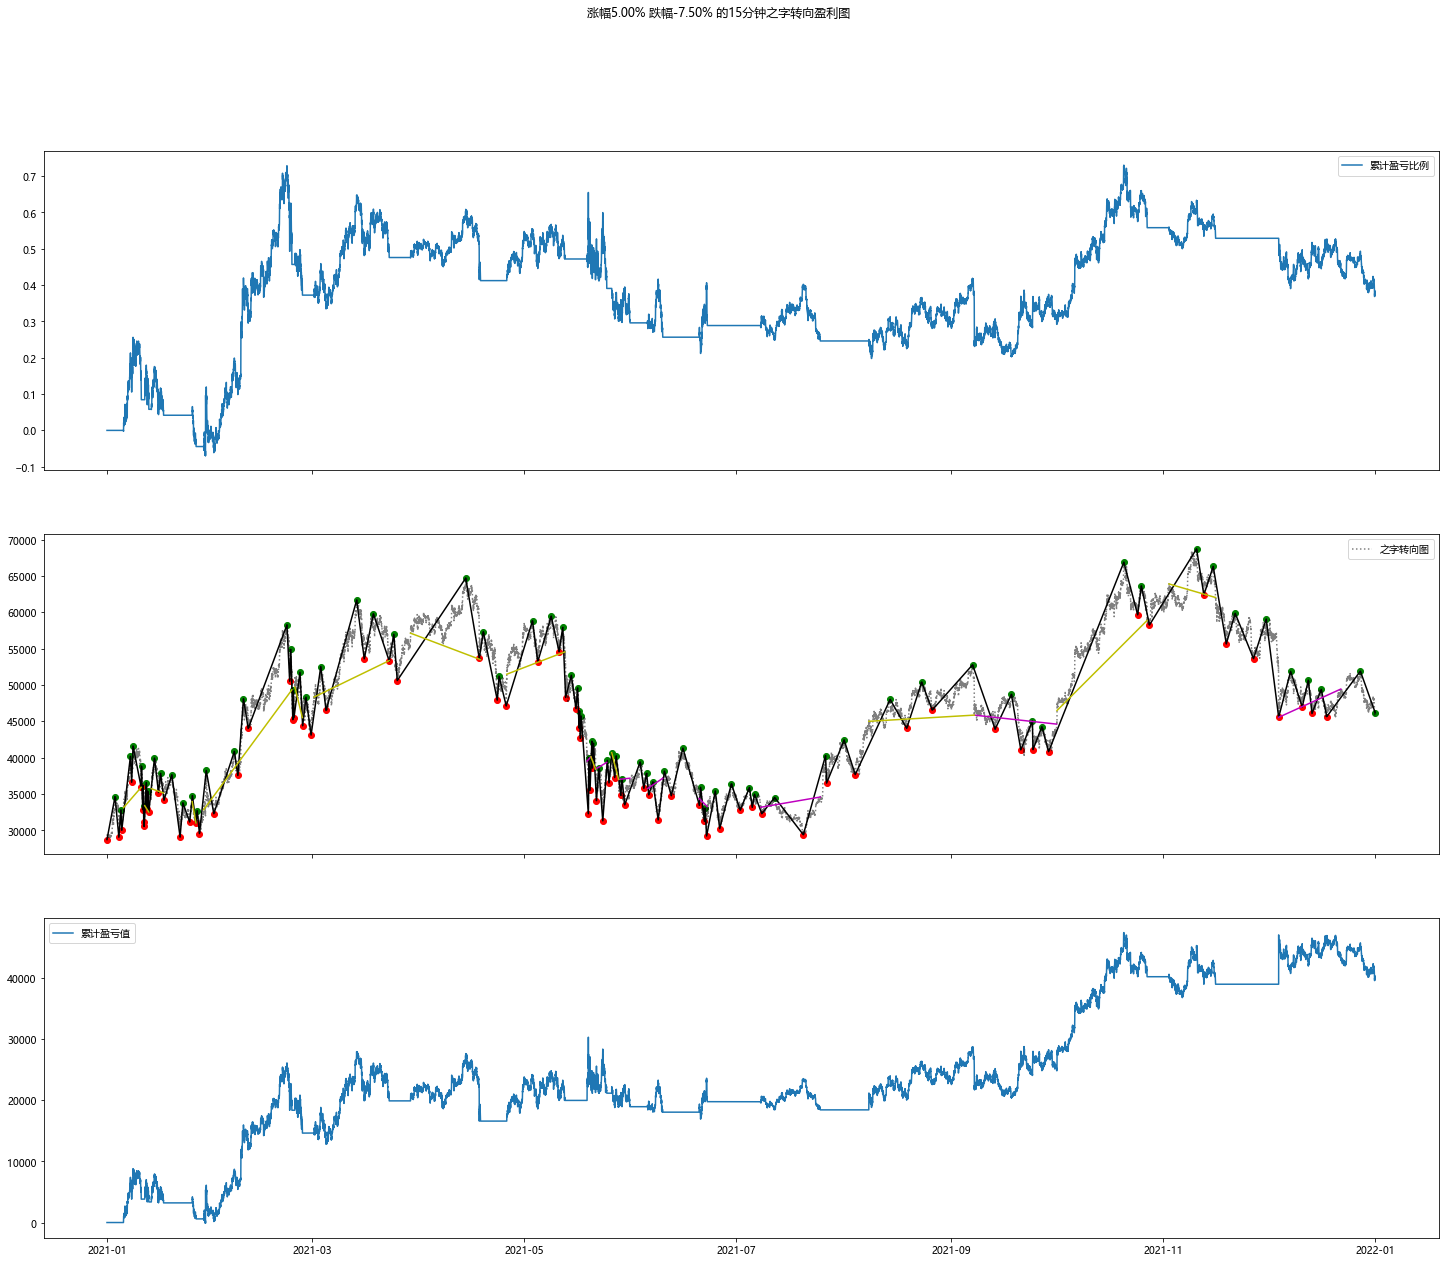

In [13]:
freq = 15
rise = 0.05
down = -0.075
take_profit_long, take_profit_short = 1, 0.9
ma_window = 200
start_date = "2021"
end_date = "2021"

data = df.resample(f'{freq}T').last().fillna(method="ffill")
if ma_window:
    ma = data.rolling(window=int(ma_window * 24 * 60 / freq)).mean().loc[start_date: end_date, "Close"]
else:
    ma = None
X = data["Close"].loc[start_date: end_date]
df_pnl, stats = backtest_both(X, rise, down, take_profit_long,take_profit_short, False, ma=ma, ma_window=ma_window)


display(pd.DataFrame([stats]))
## 绘图
pivots = df_pnl["pivots"]
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(25, 20), sharex=True)
ax1.plot(df_pnl[["cum_return"]])
ax1.legend(["累计盈亏比例"])
ax2.plot(X, 'k:', alpha=0.5)
ax2.plot(X[pivots != 0], 'k-')
ax2.scatter(X[pivots == 1].index, X[pivots == 1], color='g')
ax2.scatter(X[pivots == -1].index, X[pivots == -1], color='r')
ax3.plot(df_pnl[["pnl"]])
actions = df_pnl["actions_short"]
for i in range(len(X[actions < 0]) // 2): # 做空
    ax2.plot(X[actions < 0][i*2:i*2+2], 'm-')
actions = df_pnl["actions_long"]
for i in range(len(X[actions > 0]) // 2): # 做多
    ax2.plot(X[actions > 0][i*2:i*2+2], 'y-')
# ax2.scatter(X[actions == -1].index, X[actions == -1], color='b', s=100)
# ax2.scatter(X[actions == -2].index, X[actions == -2], color='purple', s=100)
# plot_pivots(X, pivots, ax=ax2)
fig.suptitle(f"涨幅{rise:.2%} 跌幅{down:.2%} 的{freq}分钟之字转向盈利图")
ax2.legend(["之字转向图"])
ax3.legend(["累计盈亏值"])

,rise,down,freq,take_profit_long,take_profit_short,total_return,yearly_vol,maxdrawdown,sharpe,hold_time,ma_window,start_date,end_date
0,0.045,-0.07,30.0,1,0.9,1.150236,0.795818,0.38776,1.919683,0.752911,50,2021-01-01,2021-12-31


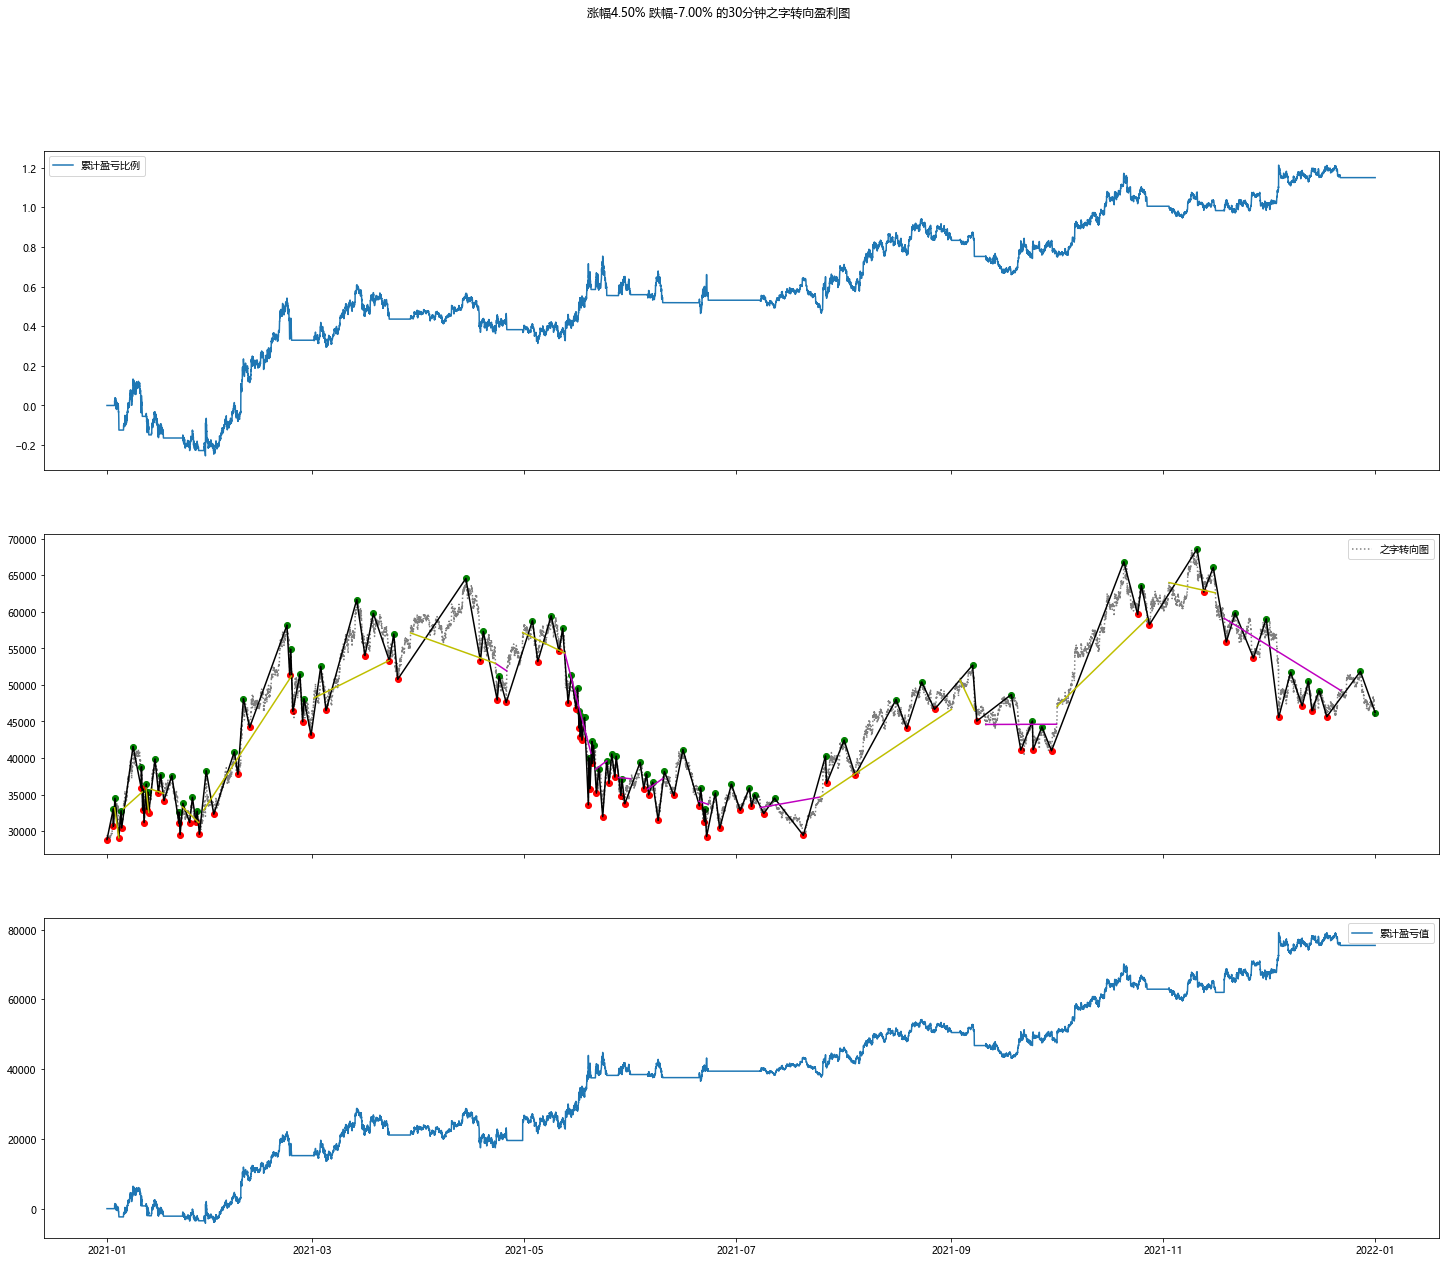

In [14]:
freq = 30
rise = 0.045
down = -0.07
take_profit_long, take_profit_short = 1, 0.9
ma_window = 50
start_date = "2021"
end_date = "2021"

data = df.resample(f'{freq}T').last().fillna(method="ffill")
if ma_window:
    ma = data.rolling(window=int(ma_window * 24 * 60 / freq)).mean().loc[start_date: end_date, "Close"]
else:
    ma = None
X = data["Close"].loc[start_date: end_date]
df_pnl, stats = backtest_both(X, rise, down, take_profit_long,take_profit_short, False, ma=ma, ma_window=ma_window)


display(pd.DataFrame([stats]))
## 绘图
pivots = df_pnl["pivots"]
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(25, 20), sharex=True)
ax1.plot(df_pnl[["cum_return"]])
ax1.legend(["累计盈亏比例"])
ax2.plot(X, 'k:', alpha=0.5)
ax2.plot(X[pivots != 0], 'k-')
ax2.scatter(X[pivots == 1].index, X[pivots == 1], color='g')
ax2.scatter(X[pivots == -1].index, X[pivots == -1], color='r')
ax3.plot(df_pnl[["pnl"]])
actions = df_pnl["actions_short"]
for i in range(len(X[actions < 0]) // 2): # 做空
    ax2.plot(X[actions < 0][i*2:i*2+2], 'm-')
actions = df_pnl["actions_long"]
for i in range(len(X[actions > 0]) // 2): # 做多
    ax2.plot(X[actions > 0][i*2:i*2+2], 'y-')
# ax2.scatter(X[actions == -1].index, X[actions == -1], color='b', s=100)
# ax2.scatter(X[actions == -2].index, X[actions == -2], color='purple', s=100)
# plot_pivots(X, pivots, ax=ax2)
fig.suptitle(f"涨幅{rise:.2%} 跌幅{down:.2%} 的{freq}分钟之字转向盈利图")
ax2.legend(["之字转向图"])
ax3.legend(["累计盈亏值"])

## 参数2

,rise,down,freq,take_profit_long,take_profit_short,total_return,yearly_vol,maxdrawdown,sharpe,hold_time,ma_window,start_date,end_date
0,0.045,-0.07,15.0,1,0.9,0.877563,0.825346,0.51047,1.408844,0.754709,50,2021-01-01,2021-12-31


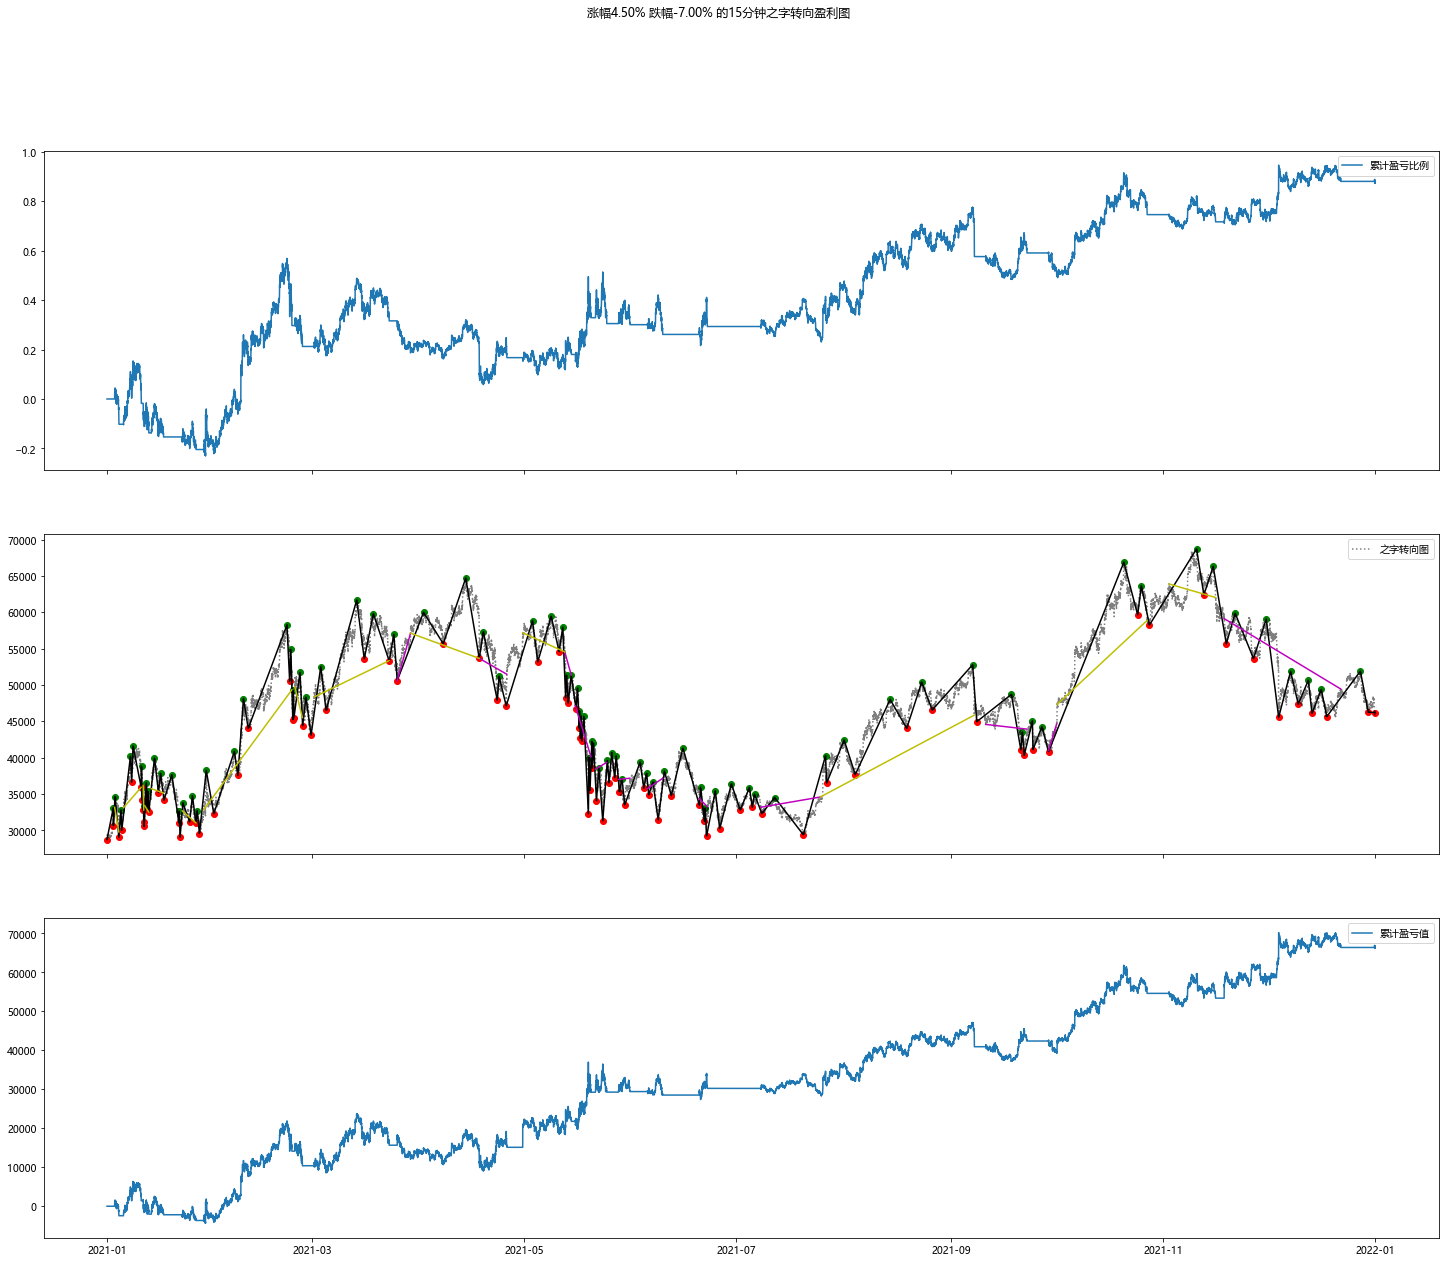

In [15]:
freq = 15
rise = 0.045
down = -0.07
take_profit_long, take_profit_short = 1, 0.9
ma_window = 50
start_date = "2021"
end_date = "2021"

data = df.resample(f'{freq}T').last().fillna(method="ffill")
if ma_window:
    ma = data.rolling(window=int(ma_window * 24 * 60 / freq)).mean().loc[start_date: end_date, "Close"]
else:
    ma = None
X = data["Close"].loc[start_date: end_date]
df_pnl, stats = backtest_both(X, rise, down, take_profit_long,take_profit_short, False, ma=ma, ma_window=ma_window)


display(pd.DataFrame([stats]))
## 绘图
pivots = df_pnl["pivots"]
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(25, 20), sharex=True)
ax1.plot(df_pnl[["cum_return"]])
ax1.legend(["累计盈亏比例"])
ax2.plot(X, 'k:', alpha=0.5)
ax2.plot(X[pivots != 0], 'k-')
ax2.scatter(X[pivots == 1].index, X[pivots == 1], color='g')
ax2.scatter(X[pivots == -1].index, X[pivots == -1], color='r')
ax3.plot(df_pnl[["pnl"]])
actions = df_pnl["actions_short"]
for i in range(len(X[actions < 0]) // 2): # 做空
    ax2.plot(X[actions < 0][i*2:i*2+2], 'm-')
actions = df_pnl["actions_long"]
for i in range(len(X[actions > 0]) // 2): # 做多
    ax2.plot(X[actions > 0][i*2:i*2+2], 'y-')
# ax2.scatter(X[actions == -1].index, X[actions == -1], color='b', s=100)
# ax2.scatter(X[actions == -2].index, X[actions == -2], color='purple', s=100)
# plot_pivots(X, pivots, ax=ax2)
fig.suptitle(f"涨幅{rise:.2%} 跌幅{down:.2%} 的{freq}分钟之字转向盈利图")
ax2.legend(["之字转向图"])
ax3.legend(["累计盈亏值"])